# Brief introduction to TCGA

**The Cancer Genome Atlas (TCGA)** contains **DNA**, **RNA**, **protein** and **epigenetic** measurements of a **large number of human tumors**.

Two versions of TCGA are available: legacy and Genomic Data Commons (GDC). **Legacy TCGA** is the original version. **GDC TCGA** is a standardized version of legacy TCGA. A few differences exist between both. *For instance, in legacy TCGA, genes are aligned on the hg19 human reference genome (GRCh37) whereas in GDC TCGA, they are aligned on the hg38 (GRCh38). In legacy TCGA, gene expression is reported as an estimated count by RSEM whereas in GDC TCGA, it is expressed in Fragments per Kilo base of transcript per Million mapped reads (FPKM). See [this publication](https://www.sciencedirect.com/science/article/pii/S2405471219302017?via%3Dihub) for more details.*

[Access to legacy TCGA](https://portal.gdc.cancer.gov/legacy-archive/search/f)

[Access to GDC TCGA](https://portal.gdc.cancer.gov/)


[Website describing TCGA program](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga)

[Website describing the GDC pipeline](https://docs.gdc.cancer.gov/Data/Bioinformatics_Pipelines/Expression_mRNA_Pipeline/)

### What is the Pan-Cancer Atlas?

The **Pan-Cancer Atlas** is an initiative created to examine the **33 tumor types** of TCGA at the same time.
- [Access to PanCan TCGA](https://gdc.cancer.gov/about-data/publications/pancanatlas)

In my opinion, there are too few details about how PanCan was collected from TCGA. Here are some clues gathered from many sources.

*The Pan-Cancer Atlas is a normalized version of legacy TCGA.*
- Clue: In the key resources table of [this publication](https://www.sciencedirect.com/science/article/pii/S0092867418303027?via%3Dihub) from the initiative, the raw genomic and clinical data are on the legacy archive. Thus, genes should be aligned on hg19.

*Gene expression data unit is “batch-corrected” “upper-quartile normalized RSEM”.*
- Clue: This unit is mentioned in [the previous paper](https://www.sciencedirect.com/science/article/pii/S0092867418303027?via%3Dihub).

*What does “batch-corrected” “upper-quartile normalized RSEM” mean?* 
- Clue for “batch-corrected”: the cancer experiments were conducted under different conditions. It is necessary to eliminate differences in the data related to the experimental setting to mitigate bias. Adjustments made by an algorithm called EB++ are detailed [here](https://www.synapse.org/#!Synapse:syn4976363). 
- Clue for RSEM: RSEM stands for RNA-Seq by Expectation Maximization (see the [reference paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-323)). It is a method quantifying genes relative abundance from RNA-Seq data. What is the unit of gene expression with this method? Well, according to the paper, it is either the estimated number of fragments derived from a gene (raw count) or the estimated fraction of fragments a value between 0 and 1 (when multiplied by 10^6, it is called Transcripts per Million (TPM)).
- Clue for “upper-quartile normalized”: the raw count is divided by the 75th percentile and multiplied by 1000 (as mentioned in [this forum](https://www.seqanswers.com/forum/bioinformatics/bioinformatics-aa/37526-whicn-normalization-methods-are-used-for-rnaseqv2-data-at-tcga?t=42911)).

So, PanCan gene expression data may be raw count divided by the 75th percentile and multiplied by 1000. 

**Be careful with gene expression samples**. In the gene expression file, some samples come from primary tumors but others come from various origins (normal solid tissue, metastatic, recurrent tumor)... This can be seen by downloading the TCGA PanCan dataset on [Xena browser](https://xenabrowser.net/) and looking at the sample_type phenotype. 

We only keep samples from primary tumors and primary blood derived cancer for this first study. In the gene expression file, sample_ID are similar to 'TCGA-DI-A2QY-01A-12R-A19W-07' or 'TCGA-DI-A2QY-11A-11R-A19W-07'. The 01 after the 'TCGA-DI-A2QY' indicates that the sample comes from a primary tissue. 02 for recurrent tumor, 03 for primary blood derived cancer  - peripheral blood, 05 for additional new primary, 06 is for metastatic, 07 for additional metastatic. The meaning of the barcode is detailed [here](https://docs.gdc.cancer.gov/Encyclopedia/pages/TCGA_Barcode/).

### Citation

When using any data from TCGA, acknowledge the TCGA Research Network in the acknowledgements section of your work. E.g. "The results published or shown here are in whole or part based upon data generated by the TCGA Research Network: https://www.cancer.gov/tcga."

# Librairies

In [6]:
import os
import sys
code_path = os.path.split(os.path.split(os.getcwd())[0])[0]
sys.path.append(code_path)

import json
from setting import *
from download_data import *
from dataset import *
from plots_and_stats import *
from utils import *

set_pyplot()

# Path

In [7]:
name = 'pancan'
save_path = get_save_path(name, code_path)
data_path = get_data_path(name)

# Dataset

### Format the dataset

In [8]:
database = 'pancan'
cancer = 'pancan'
label_name = 'type'
assert label_name in get_possible_classes(database, cancer), f"The class has to be chosen within this list {get_possible_classes(database, cancer)}."

In [9]:
data = TCGA_dataset(data_path, database, cancer, label_name)

### Describe the dataset

In [10]:
describe_dataset(data)

The dataset contains 33 classes. Here are the classes and their respective number of samples:
	ACC: 79
	BLCA: 408
	BRCA: 1095
	CESC: 304
	CHOL: 36
	COAD: 449
	DLBC: 48
	ESCA: 184
	GBM: 155
	HNSC: 520
	KICH: 66
	KIRC: 533
	KIRP: 290
	LAML: 173
	LGG: 515
	LIHC: 371
	LUAD: 515
	LUSC: 502
	MESO: 87
	OV: 305
	PAAD: 178
	PCPG: 179
	PRAD: 497
	READ: 159
	SARC: 259
	SKCM: 103
	STAD: 415
	TGCT: 134
	THCA: 505
	THYM: 120
	UCEC: 532
	UCS: 57
	UVM: 80
In total, there are 9853 samples, each of them containing 16335 features.


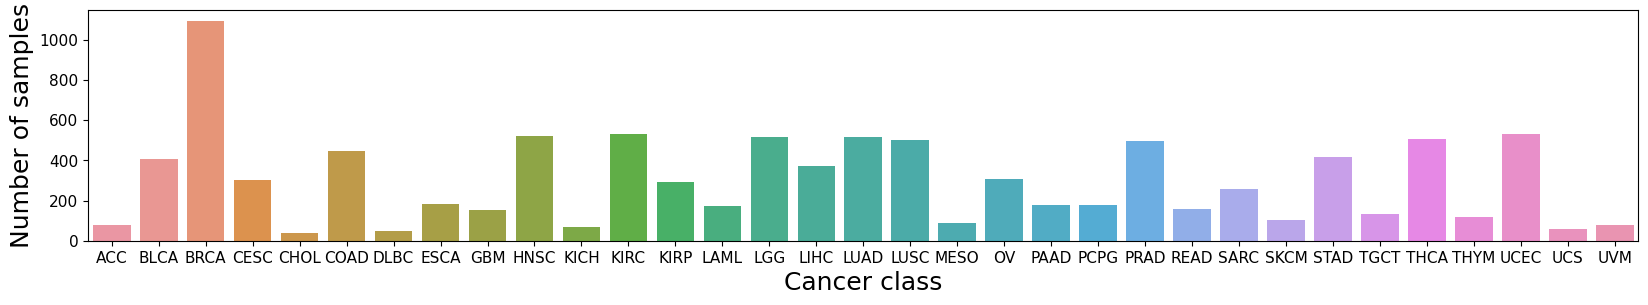

In [11]:
create_new_folder(save_path)
plot_class_imbalance(data, label_name, save_path)

In [12]:
# Each gene is represented by an expression such as 'Letters|Numbers'.
# The letters are the name of the gene, the numbers are its Entrez Gene Id.

# Code to find the index of a gene from its name.
# np.argwhere(np.array([gene.split('|')[0] for gene in data.genes_IDs]) == 'ACPP')

### Save the names of the genes to reuse them later

In [8]:
# json.dump(data.genes_IDs, open(os.path.join(save_path, "genesIds.txt",'w'))
# genes_IDs = json.load(open(os.path.join(save_path, "genesIds.txt")))